# Method 6 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

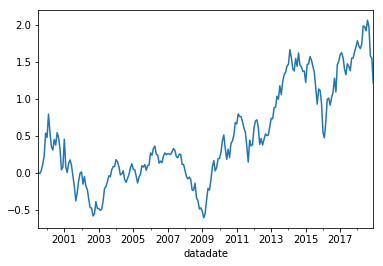

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.535169
2000-12-31   -0.299115
2001-12-31   -0.073681
2002-12-31   -0.480783
2003-12-31    1.093369
2004-12-31    0.034837
2005-12-31   -0.014727
2006-12-31    0.126178
2007-12-31   -0.106507
2008-12-31   -0.527628
2009-12-31    1.267610
2010-12-31    0.409573
2011-12-31   -0.177511
2012-12-31    0.177782
2013-12-31    0.502272
2014-12-31   -0.027412
2015-12-31   -0.183534
2016-12-31    0.292046
2017-12-31    0.078128
2018-12-31   -0.182526
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     276.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.97e-86
Time:                        14:47:37   Log-Likelihood:                 405.05
No. Observations:                 234   AIC:                            -800.1
Df Residuals:                     229   BIC:                            -782.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      2.116      0.035       0.000       0.012
mktrf          1.2921      0.081     15.992      0.000       1.133       1.451
me             0.5241      0.094      5.576      0.000       0.339       0.709
ia             0.0237      0.143      0.166      0.869      -0.258       0.305
roe           -1.3452      0.122    -11.002      0.000      -1.586      -1.104
==============================================================================
Omnibus:                      125.059   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1165.483
Skew:                           1.885   Prob(JB):                    8.29e-254
Kurtosis:                      13.263   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     79.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.56e-42
Time:                        14:47:37   Log-Likelihood:                 405.05
No. Observations:                 234   AIC:                            -800.1
Df Residuals:                     229   BIC:                            -782.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      1.883      0.060      -0.000       0.013
mktrf          1.2921      0.141      9.155      0.000       1.015       1.569
me             0.5241      0.114      4.608      0.000       0.301       0.747
ia             0.0237      0.183      0.129      0.897      -0.335       0.382
roe           -1.3452      0.190     -7.066      0.000      -1.718      -0.972
==============================================================================
Omnibus:                      125.059   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1165.483
Skew:                           1.885   Prob(JB):                    8.29e-254
Kurtosis:                      13.263   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     96.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.77e-48
Time:                        14:47:37   Log-Likelihood:                 405.05
No. Observations:                 234   AIC:                            -800.1
Df Residuals:                     229   BIC:                            -782.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.004      1.726      0.084      -0.001       0.013
mktrf          1.2921      0.141      9.191      0.000       1.017       1.568
me             0.5241      0.134      3.916      0.000       0.262       0.786
ia             0.0237      0.171      0.138      0.890      -0.312       0.359
roe           -1.3452      0.207     -6.495      0.000      -1.751      -0.939
==============================================================================
Omnibus:                      125.059   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1165.483
Skew:                           1.885   Prob(JB):                    8.29e-254
Kurtosis:                      13.263   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     181.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.73e-77
Time:                        14:47:37   Log-Likelihood:                 386.34
No. Observations:                 234   AIC:                            -760.7
Df Residuals:                     228   BIC:                            -740.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.003      1.509      0.133      -0.001       0.011
mktrf          1.4284      0.088     16.252      0.000       1.255       1.602
smb            0.6066      0.116      5.231      0.000       0.378       0.835
hml            0.3149      0.137      2.303      0.022       0.045       0.584
rmw           -1.1406      0.155     -7.378      0.000      -1.445      -0.836
cma           -0.1186      0.197     -0.604      0.547      -0.506       0.269
==============================================================================
Omnibus:                      129.267   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.396
Skew:                           2.124   Prob(JB):                    2.18e-185
Kurtosis:                      11.317   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     79.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.33e-48
Time:                        14:47:37   Log-Likelihood:                 386.34
No. Observations:                 234   AIC:                            -760.7
Df Residuals:                     228   BIC:                            -740.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.004      1.306      0.192      -0.002       0.012
mktrf          1.4284      0.097     14.705      0.000       1.238       1.619
smb            0.6066      0.137      4.438      0.000       0.339       0.874
hml            0.3149      0.221      1.423      0.155      -0.119       0.749
rmw           -1.1406      0.210     -5.426      0.000      -1.553      -0.729
cma           -0.1186      0.335     -0.354      0.724      -0.776       0.539
==============================================================================
Omnibus:                      129.267   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.396
Skew:                           2.124   Prob(JB):                    2.18e-185
Kurtosis:                      11.317   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     96.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.03e-54
Time:                        14:47:37   Log-Likelihood:                 386.34
No. Observations:                 234   AIC:                            -760.7
Df Residuals:                     228   BIC:                            -740.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.004      1.159      0.246      -0.003       0.013
mktrf          1.4284      0.083     17.245      0.000       1.266       1.591
smb            0.6066      0.133      4.552      0.000       0.345       0.868
hml            0.3149      0.186      1.695      0.090      -0.049       0.679
rmw           -1.1406      0.229     -4.975      0.000      -1.590      -0.691
cma           -0.1186      0.332     -0.357      0.721      -0.770       0.533
==============================================================================
Omnibus:                      129.267   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.396
Skew:                           2.124   Prob(JB):                    2.18e-185
Kurtosis:                      11.317   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     250.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.05e-82
Time:                        14:47:37   Log-Likelihood:                 395.58
No. Observations:                 234   AIC:                            -781.2
Df Residuals:                     229   BIC:                            -763.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.681      0.496      -0.004       0.008
mktrf          1.4652      0.077     18.916      0.000       1.313       1.618
smb            1.1527      0.097     11.921      0.000       0.962       1.343
hml           -0.0614      0.096     -0.639      0.523      -0.251       0.128
umd           -0.5554      0.063     -8.813      0.000      -0.680      -0.431
==============================================================================
Omnibus:                       95.645   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.538
Skew:                           1.467   Prob(JB):                    6.49e-131
Kurtosis:                      10.272   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     158.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-64
Time:                        14:47:37   Log-Likelihood:                 395.58
No. Observations:                 234   AIC:                            -781.2
Df Residuals:                     229   BIC:                            -763.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.717      0.473      -0.004       0.008
mktrf          1.4652      0.115     12.745      0.000       1.240       1.691
smb            1.1527      0.089     12.882      0.000       0.977       1.328
hml           -0.0614      0.128     -0.478      0.633      -0.313       0.190
umd           -0.5554      0.095     -5.833      0.000      -0.742      -0.369
==============================================================================
Omnibus:                       95.645   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.538
Skew:                           1.467   Prob(JB):                    6.49e-131
Kurtosis:                      10.272   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     142.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.84e-61
Time:                        14:47:37   Log-Likelihood:                 395.58
No. Observations:                 234   AIC:                            -781.2
Df Residuals:                     229   BIC:                            -763.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.003      0.703      0.482      -0.004       0.008
mktrf          1.4652      0.106     13.770      0.000       1.257       1.674
smb            1.1527      0.089     12.999      0.000       0.979       1.326
hml           -0.0614      0.117     -0.525      0.600      -0.291       0.168
umd           -0.5554      0.090     -6.201      0.000      -0.731      -0.380
==============================================================================
Omnibus:                       95.645   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.538
Skew:                           1.467   Prob(JB):                    6.49e-131
Kurtosis:                      10.272   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     126.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.61e-41
Time:                        14:47:37   Log-Likelihood:                 184.16
No. Observations:                 120   AIC:                            -358.3
Df Residuals:                     115   BIC:                            -344.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.005      2.392      0.018       0.002       0.022
mktrf          1.1784      0.137      8.582      0.000       0.906       1.450
me             0.3787      0.136      2.792      0.006       0.110       0.647
ia            -0.0754      0.212     -0.355      0.723      -0.496       0.345
roe           -1.4436      0.188     -7.680      0.000      -1.816      -1.071
==============================================================================
Omnibus:                       48.060   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.289
Skew:                           1.362   Prob(JB):                     4.30e-40
Kurtosis:                       8.370   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     68.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-29
Time:                        14:47:37   Log-Likelihood:                 184.16
No. Observations:                 120   AIC:                            -358.3
Df Residuals:                     115   BIC:                            -344.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.005      2.301      0.021       0.002       0.023
mktrf          1.1784      0.199      5.929      0.000       0.789       1.568
me             0.3787      0.137      2.755      0.006       0.109       0.648
ia            -0.0754      0.252     -0.299      0.765      -0.569       0.418
roe           -1.4436      0.243     -5.943      0.000      -1.920      -0.967
==============================================================================
Omnibus:                       48.060   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.289
Skew:                           1.362   Prob(JB):                     4.30e-40
Kurtosis:                       8.370   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     84.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.12e-33
Time:                        14:47:37   Log-Likelihood:                 184.16
No. Observations:                 120   AIC:                            -358.3
Df Residuals:                     115   BIC:                            -344.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.006      2.168      0.030       0.001       0.023
mktrf          1.1784      0.194      6.066      0.000       0.798       1.559
me             0.3787      0.165      2.290      0.022       0.055       0.703
ia            -0.0754      0.239     -0.316      0.752      -0.544       0.393
roe           -1.4436      0.273     -5.283      0.000      -1.979      -0.908
==============================================================================
Omnibus:                       48.060   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.289
Skew:                           1.362   Prob(JB):                     4.30e-40
Kurtosis:                       8.370   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     80.33
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-35
Time:                        14:47:37   Log-Likelihood:                 173.51
No. Observations:                 120   AIC:                            -335.0
Df Residuals:                     114   BIC:                            -318.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.006      2.085      0.039       0.001       0.023
mktrf          1.4691      0.159      9.244      0.000       1.154       1.784
smb            0.5081      0.180      2.823      0.006       0.152       0.865
hml            0.1492      0.221      0.676      0.500      -0.288       0.586
rmw           -1.0575      0.260     -4.066      0.000      -1.573      -0.542
cma           -0.0733      0.285     -0.257      0.797      -0.638       0.491
==============================================================================
Omnibus:                       63.168   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.777
Skew:                           1.952   Prob(JB):                     5.13e-48
Kurtosis:                       8.322   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     35.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-21
Time:                        14:47:37   Log-Likelihood:                 173.51
No. Observations:                 120   AIC:                            -335.0
Df Residuals:                     114   BIC:                            -318.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.006      1.975      0.048    9.29e-05       0.024
mktrf          1.4691      0.174      8.426      0.000       1.127       1.811
smb            0.5081      0.193      2.636      0.008       0.130       0.886
hml            0.1492      0.241      0.618      0.537      -0.324       0.622
rmw           -1.0575      0.289     -3.664      0.000      -1.623      -0.492
cma           -0.0733      0.397     -0.185      0.854      -0.851       0.705
==============================================================================
Omnibus:                       63.168   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.777
Skew:                           1.952   Prob(JB):                     5.13e-48
Kurtosis:                       8.322   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     40.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.95e-24
Time:                        14:47:37   Log-Likelihood:                 173.51
No. Observations:                 120   AIC:                            -335.0
Df Residuals:                     114   BIC:                            -318.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.007      1.773      0.076      -0.001       0.025
mktrf          1.4691      0.146     10.061      0.000       1.183       1.755
smb            0.5081      0.190      2.676      0.007       0.136       0.880
hml            0.1492      0.222      0.672      0.502      -0.286       0.584
rmw           -1.0575      0.326     -3.248      0.001      -1.696      -0.419
cma           -0.0733      0.395     -0.185      0.853      -0.848       0.701
==============================================================================
Omnibus:                       63.168   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.777
Skew:                           1.952   Prob(JB):                     5.13e-48
Kurtosis:                       8.322   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     124.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.71e-41
Time:                        14:47:37   Log-Likelihood:                 183.24
No. Observations:                 120   AIC:                            -356.5
Df Residuals:                     115   BIC:                            -342.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0076      0.005      1.502      0.136      -0.002       0.018
mktrf          1.4726      0.122     12.080      0.000       1.231       1.714
smb            1.0958      0.139      7.895      0.000       0.821       1.371
hml           -0.2342      0.139     -1.685      0.095      -0.510       0.041
umd           -0.5538      0.086     -6.462      0.000      -0.724      -0.384
==============================================================================
Omnibus:                       48.003   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.100
Skew:                           1.372   Prob(JB):                     5.76e-39
Kurtosis:                       8.262   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     111.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-38
Time:                        14:47:37   Log-Likelihood:                 183.24
No. Observations:                 120   AIC:                            -356.5
Df Residuals:                     115   BIC:                            -342.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0076      0.004      1.707      0.088      -0.001       0.016
mktrf          1.4726      0.174      8.483      0.000       1.132       1.813
smb            1.0958      0.123      8.895      0.000       0.854       1.337
hml           -0.2342      0.170     -1.375      0.169      -0.568       0.100
umd           -0.5538      0.102     -5.452      0.000      -0.753      -0.355
==============================================================================
Omnibus:                       48.003   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.100
Skew:                           1.372   Prob(JB):                     5.76e-39
Kurtosis:                       8.262   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     103.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.26e-37
Time:                        14:47:37   Log-Likelihood:                 183.24
No. Observations:                 120   AIC:                            -356.5
Df Residuals:                     115   BIC:                            -342.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0076      0.004      1.701      0.089      -0.001       0.016
mktrf          1.4726      0.162      9.087      0.000       1.155       1.790
smb            1.0958      0.120      9.132      0.000       0.861       1.331
hml           -0.2342      0.159     -1.476      0.140      -0.545       0.077
umd           -0.5538      0.094     -5.902      0.000      -0.738      -0.370
==============================================================================
Omnibus:                       48.003   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.100
Skew:                           1.372   Prob(JB):                     5.76e-39
Kurtosis:                       8.262   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     208.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.17e-50
Time:                        14:47:37   Log-Likelihood:                 248.36
No. Observations:                 114   AIC:                            -486.7
Df Residuals:                     109   BIC:                            -473.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.183      0.855      -0.005       0.006
mktrf          1.3869      0.082     16.841      0.000       1.224       1.550
me             0.7832      0.127      6.159      0.000       0.531       1.035
ia             0.0936      0.176      0.531      0.597      -0.256       0.443
roe           -1.3138      0.155     -8.477      0.000      -1.621      -1.007
==============================================================================
Omnibus:                       15.746   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.117
Skew:                           0.653   Prob(JB):                     5.80e-06
Kurtosis:                       4.837   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     144.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-42
Time:                        14:47:37   Log-Likelihood:                 248.36
No. Observations:                 114   AIC:                            -486.7
Df Residuals:                     109   BIC:                            -473.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.235      0.814      -0.004       0.005
mktrf          1.3869      0.109     12.705      0.000       1.173       1.601
me             0.7832      0.165      4.739      0.000       0.459       1.107
ia             0.0936      0.177      0.528      0.597      -0.254       0.441
roe           -1.3138      0.230     -5.722      0.000      -1.764      -0.864
==============================================================================
Omnibus:                       15.746   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.117
Skew:                           0.653   Prob(JB):                     5.80e-06
Kurtosis:                       4.837   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     157.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-44
Time:                        14:47:37   Log-Likelihood:                 248.36
No. Observations:                 114   AIC:                            -486.7
Df Residuals:                     109   BIC:                            -473.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.257      0.797      -0.003       0.004
mktrf          1.3869      0.108     12.837      0.000       1.175       1.599
me             0.7832      0.198      3.949      0.000       0.395       1.172
ia             0.0936      0.191      0.489      0.625      -0.282       0.469
roe           -1.3138      0.236     -5.562      0.000      -1.777      -0.851
==============================================================================
Omnibus:                       15.746   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.117
Skew:                           0.653   Prob(JB):                     5.80e-06
Kurtosis:                       4.837   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     145.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.69e-46
Time:                        14:47:37   Log-Likelihood:                 241.97
No. Observations:                 114   AIC:                            -471.9
Df Residuals:                     108   BIC:                            -455.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.517      0.607      -0.007       0.004
mktrf          1.4292      0.083     17.124      0.000       1.264       1.595
smb            0.7228      0.135      5.335      0.000       0.454       0.991
hml            0.5190      0.173      3.003      0.003       0.176       0.862
rmw           -1.2597      0.212     -5.954      0.000      -1.679      -0.840
cma           -0.2224      0.269     -0.828      0.409      -0.755       0.310
==============================================================================
Omnibus:                        6.532   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                7.111
Skew:                           0.368   Prob(JB):                       0.0286
Kurtosis:                       3.977   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     114.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.60e-41
Time:                        14:47:37   Log-Likelihood:                 241.97
No. Observations:                 114   AIC:                            -471.9
Df Residuals:                     108   BIC:                            -455.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.468      0.640      -0.008       0.005
mktrf          1.4292      0.086     16.585      0.000       1.260       1.598
smb            0.7228      0.142      5.081      0.000       0.444       1.002
hml            0.5190      0.166      3.121      0.002       0.193       0.845
rmw           -1.2597      0.239     -5.279      0.000      -1.727      -0.792
cma           -0.2224      0.234     -0.950      0.342      -0.682       0.237
==============================================================================
Omnibus:                        6.532   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                7.111
Skew:                           0.368   Prob(JB):                       0.0286
Kurtosis:                       3.977   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     114.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-41
Time:                        14:47:37   Log-Likelihood:                 241.97
No. Observations:                 114   AIC:                            -471.9
Df Residuals:                     108   BIC:                            -455.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.467      0.640      -0.008       0.005
mktrf          1.4292      0.091     15.720      0.000       1.251       1.607
smb            0.7228      0.161      4.477      0.000       0.406       1.039
hml            0.5190      0.142      3.654      0.000       0.241       0.797
rmw           -1.2597      0.214     -5.896      0.000      -1.678      -0.841
cma           -0.2224      0.247     -0.902      0.367      -0.706       0.261
==============================================================================
Omnibus:                        6.532   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                7.111
Skew:                           0.368   Prob(JB):                       0.0286
Kurtosis:                       3.977   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     151.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-43
Time:                        14:47:37   Log-Likelihood:                 232.43
No. Observations:                 114   AIC:                            -454.9
Df Residuals:                     109   BIC:                            -441.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.840      0.403      -0.009       0.004
mktrf          1.4706      0.090     16.386      0.000       1.293       1.648
smb            1.0244      0.140      7.320      0.000       0.747       1.302
hml            0.4157      0.144      2.884      0.005       0.130       0.701
umd           -0.4475      0.109     -4.116      0.000      -0.663      -0.232
==============================================================================
Omnibus:                       10.419   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.961
Skew:                           0.359   Prob(JB):                     0.000126
Kurtosis:                       4.807   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     176.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-46
Time:                        14:47:37   Log-Likelihood:                 232.43
No. Observations:                 114   AIC:                            -454.9
Df Residuals:                     109   BIC:                            -441.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.988      0.323      -0.008       0.003
mktrf          1.4706      0.092     16.034      0.000       1.291       1.650
smb            1.0244      0.140      7.313      0.000       0.750       1.299
hml            0.4157      0.156      2.659      0.008       0.109       0.722
umd           -0.4475      0.113     -3.946      0.000      -0.670      -0.225
==============================================================================
Omnibus:                       10.419   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.961
Skew:                           0.359   Prob(JB):                     0.000126
Kurtosis:                       4.807   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     233.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-52
Time:                        14:47:37   Log-Likelihood:                 232.43
No. Observations:                 114   AIC:                            -454.9
Df Residuals:                     109   BIC:                            -441.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -1.024      0.306      -0.008       0.002
mktrf          1.4706      0.093     15.851      0.000       1.289       1.652
smb            1.0244      0.131      7.812      0.000       0.767       1.281
hml            0.4157      0.147      2.828      0.005       0.128       0.704
umd           -0.4475      0.112     -3.982      0.000      -0.668      -0.227
==============================================================================
Omnibus:                       10.419   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.961
Skew:                           0.359   Prob(JB):                     0.000126
Kurtosis:                       4.807   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""